In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
!pip install contractions
import contractions
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

In [135]:
train = pd.read_csv("https://raw.githubusercontent.com/DamiFur/DiploDatos-StanceDetection/master/train.csv", sep=',', encoding="latin1").fillna(method="ffill")
test = pd.read_csv("https://raw.githubusercontent.com/DamiFur/DiploDatos-StanceDetection/master/test.csv", sep=',', encoding="latin1").fillna(method="ffill")

In [136]:
abortion_train = train[train["Target"] == "Legalization of Abortion"]
abortion_test = test[test["Target"] == "Legalization of Abortion"]

In [137]:
abortion_train.drop(columns = ["Target", "Opinion Towards", "Sentiment"], inplace=True)
abortion_test.drop(columns = ["Target", "Opinion Towards", "Sentiment"], inplace=True)

In [138]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

In [139]:
def preprocesar(text, keep_hashtags=True, remove_numbers=True):
    
    text = contractions.fix(text) 
    
    toks = tokenizer.tokenize(text)
    
    ret = []
    for tok in toks:
        
        if re.match('https?://[A-Za-z0-9./]+',tok):
            continue

        if re.match('[A-Za-z0-9./]+@[A-Za-z0-9./]+',tok):
            continue
            
        if re.match(r'[^\w\s\#,]',tok): #emoji
            continue
            
        if re.match('[^?!.,]*[?.!,]$',tok): #puntuaciones
            continue
        
        if tok.isnumeric() and remove_numbers:
            continue
        ret.append(tok)
    return " ".join(ret)

In [140]:
abortion_train["Tweet"] = abortion_train["Tweet"].apply(lambda x: preprocesar(x))
abortion_test["Tweet"] = abortion_test["Tweet"].apply(lambda x: preprocesar(x))

In [141]:
train_abortion, validation_abortion = train_test_split(
    abortion_train, 
    test_size=0.2, 
    random_state=42
)

In [142]:
y_test = abortion_test["Stance"]
y_train = train_abortion["Stance"]
y_validation = validation_abortion["Stance"]

In [143]:
def dataset_vectorizer(input_train, input_validation, input_test):
    text_train = input_train["Tweet"]
    text_validation = input_validation["Tweet"]
    text_test = input_test["Tweet"]

    vectorizer = CountVectorizer(
        binary=True, min_df=0.004, max_df=0.7, ngram_range=(1, 3)
    )

    X_result = vectorizer.fit_transform([*text_train, *text_validation, *text_test])

    VEC_train = X_result[:len(text_train)]
    VEC_validation = X_result[len(text_train):-len(text_test)]
    VEC_test = X_result[-len(text_test):]
    
    return VEC_train, VEC_validation, VEC_test

In [144]:
VEC_train_abortion, VEC_validation_abortion, VEC_test_abortion = dataset_vectorizer(train_abortion, validation_abortion, abortion_test)

In [145]:
VEC_validation_abortion.sort_indices()
VEC_train_abortion.sort_indices()
VEC_test_abortion.sort_indices()

In [146]:
# El output de nuestra red neuronal tiene que ser un valor numérico
codes = {}
codes["NONE"] = 0
codes["FAVOR"] = 1
codes["AGAINST"] = 2

def toNumeric(stance):
    return codes[stance]

labels = np.array(y_train.apply(lambda x: toNumeric(x)))
validation = np.array(y_validation.apply(lambda x: toNumeric(x)))
test = np.array(y_test.apply(lambda x: toNumeric(x)))

# labels = list(map(toNumeric, train_abortion["Stance"]))
# validation = list(map(toNumeric, validation_abortion["Stance"]))

In [148]:
input_dim = VEC_train_abortion.shape[1]

alpha = 0.1
nodes_per_hidden_layer = 20
hidden_layer_depth = 1
activation = "softmax"# softmax, relu, tanh,
learning_rate = 1e-02

seed = 7
numpy.random.seed(seed)

model = Sequential()
model.add(Dense(nodes_per_hidden_layer, input_dim=input_dim))

# Esto lo pueden usar si quieren agregar varias capas
#for i in range(hidden_layer_depth):
#     model.add(Dense(nodes_per_hidden_layer))

model.add(Activation(activation))

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=learning_rate), 
              metrics=['accuracy'])

# model.summary()
history = model.fit(x=VEC_train_abortion, y=labels, batch_size=1, epochs=1000, verbose=2, validation_data=(VEC_validation_abortion, validation))

Epoch 1/1000
522/522 - 0s - loss: 1.9254 - accuracy: 0.5000 - val_loss: 1.2962 - val_accuracy: 0.5878
Epoch 2/1000
522/522 - 0s - loss: 1.1642 - accuracy: 0.5479 - val_loss: 1.0139 - val_accuracy: 0.6107
Epoch 3/1000
522/522 - 0s - loss: 0.9338 - accuracy: 0.6322 - val_loss: 0.9016 - val_accuracy: 0.6336
Epoch 4/1000
522/522 - 0s - loss: 0.8110 - accuracy: 0.7165 - val_loss: 0.8388 - val_accuracy: 0.6641
Epoch 5/1000
522/522 - 0s - loss: 0.7295 - accuracy: 0.7874 - val_loss: 0.7944 - val_accuracy: 0.6565
Epoch 6/1000
522/522 - 0s - loss: 0.6707 - accuracy: 0.7989 - val_loss: 0.7726 - val_accuracy: 0.6947
Epoch 7/1000
522/522 - 0s - loss: 0.6237 - accuracy: 0.8276 - val_loss: 0.7476 - val_accuracy: 0.6870
Epoch 8/1000
522/522 - 0s - loss: 0.5852 - accuracy: 0.8372 - val_loss: 0.7332 - val_accuracy: 0.7252
Epoch 9/1000
522/522 - 0s - loss: 0.5531 - accuracy: 0.8544 - val_loss: 0.7200 - val_accuracy: 0.7328
Epoch 10/1000
522/522 - 0s - loss: 0.5253 - accuracy: 0.8525 - val_loss: 0.7141 - 

In [ ]:
# model.save('softmax_1000_classification_model.h5')

# from keras.models import load_model
# pretrained_model = load_model('MNIST_classification_model.h5')

In [149]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

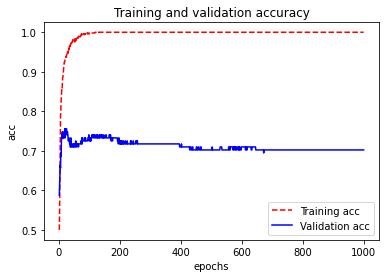

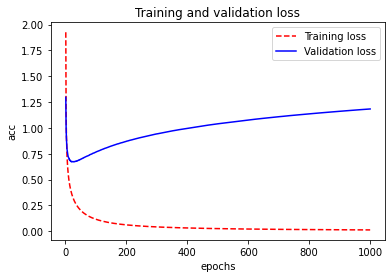

<Figure size 432x288 with 0 Axes>

In [150]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--', label='Training loss' )
plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [151]:
print('numero de epoch para menor valor de loss (validation)')

print(val_loss.index(min(val_loss)))

print('numero de epoch para mayor valor de accuracy (validation)')

print(val_acc.index(max(val_acc)))

numero de epoch para menor valor de loss (validation)
27
numero de epoch para mayor valor de accuracy (validation)
18


In [152]:
y_pred_test =  model.predict_classes(VEC_test_abortion)

In [153]:
accuracy_test = accuracy_score(test, y_pred_test)
f1_test_micro = f1_score(test, y_pred_test, average="micro", labels=[0,1,2])
f1_test_macro = f1_score(test, y_pred_test, average="macro", labels=[0,1,2])
f1_test = f1_score(test, y_pred_test, average=None, labels=[0,1,2])
# f1_test_average = #TODO
f1_test_average = (f1_test[1] + f1_test[2]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

print("Exactitud del algoritmo para conjunto de test: %.2f" % accuracy_test)

Accuracy para conjunto de test: 0.64
F1 micro para conjunto de test: 0.64
F1 macro para conjunto de test: 0.57
F1 average para conjunto de test: 0.62
Exactitud del algoritmo para conjunto de test: 0.64


### Entrenamos con 30 epochs

In [154]:
input_dim = VEC_train_abortion.shape[1]

alpha = 0.1
nodes_per_hidden_layer = 20
hidden_layer_depth = 1
activation = "softmax"# softmax, relu, tanh,
learning_rate = 1e-02

model = Sequential()
model.add(Dense(nodes_per_hidden_layer, input_dim=input_dim))

# Esto lo pueden usar si quieren agregar varias capas
#for i in range(hidden_layer_depth):
#     model.add(Dense(nodes_per_hidden_layer))

model.add(Activation(activation))

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=learning_rate), 
              metrics=['accuracy'])

history = model.fit(x=VEC_train_abortion, y=labels, batch_size=1, epochs=50, verbose=1, validation_data=(VEC_validation_abortion, validation))

Epoch 1/50
522/522 [==============================] - 0s 826us/step - loss: 1.9381 - accuracy: 0.4808 - val_loss: 1.2788 - val_accuracy: 0.5878
Epoch 2/50
522/522 [==============================] - 0s 679us/step - loss: 1.1699 - accuracy: 0.5498 - val_loss: 1.0095 - val_accuracy: 0.6107
Epoch 3/50
522/522 [==============================] - 0s 721us/step - loss: 0.9407 - accuracy: 0.6111 - val_loss: 0.9068 - val_accuracy: 0.6718
Epoch 4/50
522/522 [==============================] - 0s 695us/step - loss: 0.8188 - accuracy: 0.7337 - val_loss: 0.8359 - val_accuracy: 0.6641
Epoch 5/50
522/522 [==============================] - 0s 693us/step - loss: 0.7375 - accuracy: 0.7586 - val_loss: 0.7952 - val_accuracy: 0.6641
Epoch 6/50
522/522 [==============================] - 0s 720us/step - loss: 0.6766 - accuracy: 0.7854 - val_loss: 0.7684 - val_accuracy: 0.7099
Epoch 7/50
522/522 [==============================] - 0s 694us/step - loss: 0.6287 - accuracy: 0.8372 - val_loss: 0.7474 - val_accuracy:

In [155]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 432x288 with 0 Axes>

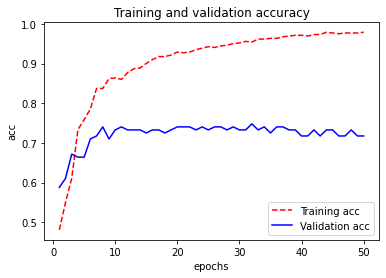

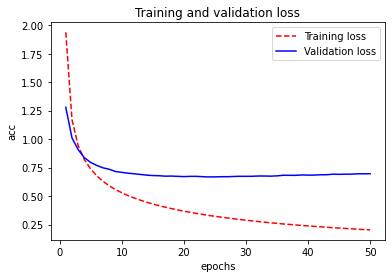

<Figure size 432x288 with 0 Axes>

In [156]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--', label='Training loss' )
plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [157]:
y_pred_test =  model.predict_classes(VEC_test_abortion)

In [158]:
accuracy_test = accuracy_score(test, y_pred_test)
f1_test_micro = f1_score(test, y_pred_test, average="micro", labels=[0,1,2])
f1_test_macro = f1_score(test, y_pred_test, average="macro", labels=[0,1,2])
f1_test = f1_score(test, y_pred_test, average=None, labels=[0,1,2])
# f1_test_average = #TODO
f1_test_average = (f1_test[1] + f1_test[2]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

print("Exactitud del algoritmo para conjunto de test: %.2f" % accuracy_test)

Accuracy para conjunto de test: 0.64
F1 micro para conjunto de test: 0.64
F1 macro para conjunto de test: 0.56
F1 average para conjunto de test: 0.64
Exactitud del algoritmo para conjunto de test: 0.64


**Se realizó un primer entrenamiento con 1000 epoch y batch size = 1, observamos que aproximadamente luego del epoch 50 comienza a descender el accuracy y a aumentar el valor de loss, obteniendo las siguientes metricas.**

Accuracy para conjunto de test: 0.64  
F1 micro para conjunto de test: 0.64  
F1 macro para conjunto de test: 0.57  
F1 average para conjunto de test: 0.62  
Exactitud del algoritmo para conjunto de test: 0.64  

**Por lo cual decidimos realizar un segundo entrenamiento pero solo con 50 epochs, obteniendo las siguientes metricas.**

Accuracy para conjunto de test: 0.64  
F1 micro para conjunto de test: 0.64  
F1 macro para conjunto de test: 0.54  
F1 average para conjunto de test: 0.64  
Exactitud del algoritmo para conjunto de test: 0.64  



In [171]:
def create_model(activation='softmax'):
    input_dim = VEC_train_abortion.shape[1]
    alpha = 0.1
    nodes_per_hidden_layer = 20
    hidden_layer_depth = 1
    # activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    learning_rate = 1e-02

    model = Sequential()
    model.add(Dense(nodes_per_hidden_layer, input_dim=input_dim))
    model.add(Activation(activation))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=learning_rate), 
              metrics=['accuracy'])
    return model

In [159]:


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from time import time
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

start=time()
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=1)
optimizers = ['SGD']
# init = ['glorot_uniform', 'normal', 'uniform']
epochs = np.array([50])
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid_result = grid.fit(VEC_train_abortion, labels) #(X_train, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
417/417 [==============================] - 0s 548us/step - loss: 2.0583 - accuracy: 0.4820
Epoch 2/50
417/417 [==============================] - 0s 555us/step - loss: 1.2705 - accuracy: 0.5180
Epoch 3/50
417/417 [==============================] - 0s 541us/step - loss: 1.0185 - accuracy: 0.6091
Epoch 4/50
417/417 [==============================] - 0s 567us/step - loss: 0.8803 - accuracy: 0.6835
Epoch 5/50
417/417 [==============================] - 0s 567us/step - loss: 0.7877 - accuracy: 0.7458
Epoch 6/50
417/417 [==============================] - 0s 548us/step - loss: 0.7220 - accuracy: 0.8106
Epoch 7/50
417/417 [==============================] - 0s 553us/step - loss: 0.6693 - accuracy: 0.8297
Epoch 8/50
417/417 [==============================] - 0s 558us/step - loss: 0.6269 - accuracy: 0.8393
Epoch 9/50
417/417 [==============================] - 0s 550us/step - loss: 0.5907 - accuracy: 0.8513
Epoch 10/50
417/417 [==============================] - 0s 558us/step - loss: 0.559

In [160]:
y_pred_test = grid_result.predict(VEC_test_abortion)

In [161]:
accuracy_test = accuracy_score(test, y_pred_test)
f1_test_micro = f1_score(test, y_pred_test, average="micro", labels=[0,1,2])
f1_test_macro = f1_score(test, y_pred_test, average="macro", labels=[0,1,2])
f1_test = f1_score(test, y_pred_test, average=None, labels=[0,1,2])
# f1_test_average = #TODO
f1_test_average = (f1_test[1] + f1_test[2]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

print("Exactitud del algoritmo para conjunto de test: %.2f" % accuracy_test)

Accuracy para conjunto de test: 0.61
F1 micro para conjunto de test: 0.61
F1 macro para conjunto de test: 0.55
F1 average para conjunto de test: 0.63
Exactitud del algoritmo para conjunto de test: 0.61


### VOTING

In [172]:
from sklearn.ensemble import VotingClassifier

clf1 = RandomForestClassifier(random_state=2, n_estimators=10, criterion='entropy')
clf2 = SVC(C = 1.0, kernel = "rbf", gamma=0.5, tol = 1e-3)
clf3 = KerasClassifier(build_fn=create_model, epochs=50, batch_size=1, verbose=0)
clf3._estimator_type = "classifier"  

eclf1 = VotingClassifier(estimators=[('rf', clf1), ('svc', clf2), ('keras', clf3)], voting='hard')
eclf1 = eclf1.fit(VEC_train_abortion, labels)
print(eclf1.predict(VEC_test_abortion))

[2 2 2 2 2 2 2 2 2 2 2 1 0 2 0 2 2 2 2 2 2 2 2 1 2 1 1 2 2 0 0 2 2 2 2 2 2
 2 2 0 2 2 2 2 0 2 2 2 2 1 2 2 2 0 2 2 2 0 2 2 0 2 2 2 2 2 0 0 0 2 2 2 2 0
 2 0 2 0 2 0 2 2 2 2 0 2 2 2 0 0 2 2 2 2 2 1 2 0 0 2 2 2 0 0 2 2 0 0 0 0 2
 2 0 2 2 2 2 2 2 0 2 0 1 0 0 0 2 0 2 2 2 2 0 2 2 2 1 0 0 2 2 2 2 0 2 1 0 1
 2 0 2 2 2 2 2 1 0 0 0 0 2 1 1 2 0 2 0 0 0 2 0 0 2 2 2 2 0 2 0 2 2 2 2 2 1
 2 2 2 2 0 2 2 1 0 2 2 0 0 2 2 0 2 2 0 2 2 0 2 0 0 2 2 0 2 2 2 2 2 0 2 0 2
 2 2 2 0 2 2 0 2 2 2 2 2 0 0 0 2 0 2 2 2 2 2 2 2 2 2 2 2 1 0 2 2 2 2 2 2 2
 2 0 2 2 0 0 1 2 0 2 2 0 2 2 2 2 2 0 2 2 2]


In [173]:
y_pred_test = eclf1.predict(VEC_test_abortion)

accuracy_test = accuracy_score(test, y_pred_test)
f1_test_micro = f1_score(test, y_pred_test, average="micro", labels=[0,1,2])
f1_test_macro = f1_score(test, y_pred_test, average="macro", labels=[0,1,2])
f1_test = f1_score(test, y_pred_test, average=None, labels=[0,1,2])
# f1_test_average = #TODO
f1_test_average = (f1_test[1] + f1_test[2]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

print("Exactitud del algoritmo para conjunto de test: %.2f" % accuracy_test)

Accuracy para conjunto de test: 0.62
F1 micro para conjunto de test: 0.62
F1 macro para conjunto de test: 0.48
F1 average para conjunto de test: 0.55
Exactitud del algoritmo para conjunto de test: 0.62
